# `Applied Machine Learning`

## `Lab 9. MLP`

###Approved by Donat Balaj (dbalaj@constructor.university)




Rules:

The use of AI and any other violations mentioned in the Academic Integrity Policy is strictly prohibited. For more information, please refer to the Academic Integrity Policy of Constructor University: https://constructor.university/sites/default/files/2024-09/CAI%202024%20vf.pdf If a student's work violates these rules, the work will be disregarded, no points will be awarded, and the Academic Integrity team may be notified.

Students are not allowed to copy and paste examples described in the lab if the example contains several lines of code and implements a non-trivial idea. Please write the code on your own. Violations of this rule will result in point deductions. Even for theoretical answers, copying and pasting will not be tolerated; please use your own words to enhance your critical thinking.

Late submissions will not be accepted. Even if a few seconds late, work submitted after the given deadline will not be graded. Additionally, any work that has been uploaded but not formally submitted will be disregarded. If you experience technical issues, you may submit your homework via email, but not after the given deadline.

### `0. Introduction`

In this part we will use the PyTorch framework for training neural networks. Namely, you have to train a fully connected neural network to predict the year of release of a song based on its audio features. For this we will use [Million Songs Dataset](https://samyzaf.com/ML/song_year/song_year.html).

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import tqdm.autonotebook as tqdm
from IPython.display import clear_output

import matplotlib_inline
import matplotlib.pyplot as plt
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

np.random.seed(0xFA1AFE1)

C:\Users\elgha\AppData\Local\Temp\ipykernel_4204\2650367251.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


Let's start by downloading and processing the data:

In [3]:
data_path = './YearPredictionMSD.txt.zip'

if not os.path.exists(data_path):
    ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [4]:
df = pd.read_csv(data_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Let's look at the statistics on the data:

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


The target variable, the year the song was released, is written in the first column. Let's look at its distribution:

# of unique values: 89
Target variable range: 1922 - 2011


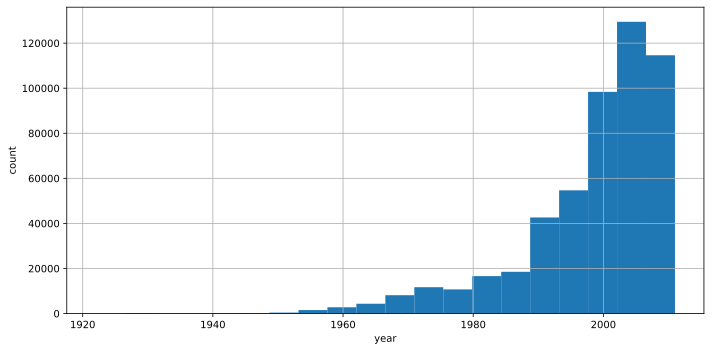

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist(df.iloc[:, 0], bins=20)

ax.grid(True)
ax.set_xlabel('year')
ax.set_ylabel('count')

print(f'# of unique values: {np.unique(df.iloc[:, 0]).size}')
print(f'Target variable range: {df.iloc[:, 0].min()} - {df.iloc[:, 0].max()}')

fig.tight_layout()
plt.show()

Let's split the data into training and test (don't change anything here so that the split is the same for everyone):

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [8]:
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False)

assert X_train.shape == (386508, 90) and X_test.shape == (128837, 90)
X_train.shape, X_test.shape

((386508, 90), (128837, 90))

<font color='brown'>**Exercise 1.**
We will use **MSE** as a quality metric. Before training neural networks, we need to test a few simple baselines so that we have something to compare more complex algorithms with. To do this:
1. Train `Ridge` regression from `sklearn` and calculate the quality
2. Calculate the quality at the best constant prediction

</font>

In [9]:
model = Ridge() ### your code here
model.fit(X_train, y_train)
model_mse = mean_squared_error(y_test,model.predict(X_test)) ### your code here

print(f'Ridge MSE: {model_mse}')
assert abs(model_mse - 89.749) < 1e-3

Ridge MSE: 89.74966397222072


In [10]:
constant_mse = mean_squared_error(y_test, np.full_like(y_test, fill_value=y_train.mean(), dtype=np.float64)) ### your code here

print(f'MSE for best constant prediction: {constant_mse}')

assert abs(constant_mse - 117.625) < 1e-3

MSE for best constant prediction: 117.62580230734426


Now let's start experimenting with neural networks. First, let's separate validation from the data:

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0xE2E4)

assert X_train.shape == (289881, 90) and X_val.shape == (96627, 90)
X_train.shape, X_val.shape

((289881, 90), (96627, 90))

### `Part 1. Setting up a neural network`

<font color='brown'>**Exercise 2.** Fill in the blanks in the `train_and_validate` function. It will help us run experiments. You can see through the comments for the next tasks to get more information on PyTorch framework and base classes.</font>

In [12]:
def plot_losses(
    train_losses: list[float], train_metrics: list[float],
    val_losses: list[float], val_metrics: list[float]
):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axes[0].plot(range(1, len(val_losses) + 1), val_losses, label='validation')
    axes[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axes[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='validation')

    if max(train_losses) / min(train_losses) > 10:
        axes[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axes[0].set_yscale('log')

    for ax in axes:
        ax.set_xlabel('Epoch')
        ax.grid(True)
        ax.legend()

    axes[0].set_ylabel('Loss')
    axes[1].set_ylabel('MSE')
    fig.tight_layout()
    plt.show()

In [13]:
def train_and_validate(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer, criterion: torch.nn.Module, metric,
    train_loader: DataLoader, val_loader: DataLoader, num_epochs: int, verbose: bool = True
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer  chained to a model
      - criterion: loss function class
      - metrics: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE after the last epoch
      - val_mse: validation MSE after the last epoch
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        running_loss, running_metric = 0.0, 0.0

        # Switch network submodules to train mode, e.g. it influences on batch-norm, dropout
        # See: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
        ### your code here
        model.train()
        for X_batch, y_batch in (
            pbar := tqdm.tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}', disable=not verbose)
        ):
            # Perform one step of gradient descent
            # See: https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step
            #   for detains

            # Zero out grads, collected from previous batch
            ### your code here
            optimizer.zero_grad()

            # Forward pass
            predictions = model(X_batch) ### your code here

            # Compute loss
            loss = criterion(predictions.squeeze(), y_batch) ### your code here

            # Make backward pass to compute gradients
            ### your code here
            loss.backward()

            # Make gradient step using optimizer
            ### your code here
            optimizer.step()

            # Compute metric using predictions and targets
            metric_value = metric(predictions.squeeze(), y_batch) ### your code here

            running_loss += loss.item() * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]
            if verbose:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        train_losses.append(running_loss / len(train_loader.dataset))
        train_metrics.append(running_metric / len(train_loader.dataset))

        running_loss, running_metric = 0.0, 0.0

        # Switch network submodules to eval mode, e.g. it influences on batch-norm, dropout
        # See: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval
        ### your code here
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in (
            pbar := tqdm.tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}', disable=not verbose)
            ):
            # Forward pass
                predictions = model(X_batch) ### your code here

            # Compute loss
                loss = criterion(predictions.squeeze(), y_batch) ### your code here

            # Compute metric using predictions and targets
                metric_value = metric(predictions.squeeze(), y_batch) ### your code here

                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]
                if verbose:
                    pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        val_losses.append(running_loss / len(val_loader.dataset))
        val_metrics.append(running_metric / len(val_loader.dataset))

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f'Validation MSE: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]

### Dataset Preparation

We need to modify dataset a bit to make it suitable for neural network training

<font color='brown'>Transform the target variable so that its values range from $0$ to $C-1$, where $C$ — number of classes (better pass the converted value to the DataLoader, we will still need the original one)</font>

In [17]:
target_test, target_train, target_val =y_test -y_train.min(), y_train - y_train.min(),y_val - y_train.min() ### your code here

assert np.sum(target_test > 90) == 0
assert np.sum(target_train > 90) == 0
assert np.sum(target_val > 90) == 0

<font color='brown'>Create dataset for indexing data.
Hints:
1. Convert data to `torch.Tensor` of corresponding types (`torch.float32` and `torch.long`)

    See [tutorial](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) for more info, but overall torch tensors behave exactly like numpy arrays
    
    Minor differences from numpy:
    * `axis` -> `dim`: `np.sum(A, axis=0)` -> `torch.sum(A, dim=0)`
    * `.reshape` -> `.view`/`.reshape`
    * `.astype` -> `.to`/`.type`
1. Use [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) to index X and y simultaneously

    See [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more info

</font>

In [18]:
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(target_val, dtype=torch.long)) ### your code here
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(target_train, dtype=torch.long)) ### your code here

assert len(val_ds) == 96627 and len(train_ds) == 289881

assert len(val_ds[0]) == 2 and len(train_ds[0]) == 2
assert val_ds[0][0].shape == (90, ) and val_ds[0][1].shape == ()
assert train_ds[0][0].shape == (90, ) and train_ds[0][1].shape == ()

val_ds[0]

(tensor([ 4.9814e+01,  2.1554e+01,  2.2072e+01, -4.0647e+00, -2.6312e+01,
         -2.1766e+01, -5.0466e+00, -5.0849e+00,  5.6026e+00,  4.7512e+00,
          1.0105e+00,  5.2294e+00,  5.8359e+01,  2.4072e+03,  8.3569e+02,
          3.3101e+02,  6.2257e+02,  3.2318e+02,  3.1044e+02,  2.7583e+02,
          1.5219e+02,  1.3494e+02,  1.2195e+02,  1.3037e+02,  2.4669e+02,
          2.3254e+02,  3.2583e+01,  4.0379e+01, -4.3841e+01,  5.6011e+01,
          4.0721e+01,  4.3293e+00,  1.1106e+01, -3.7591e+01,  2.4224e+01,
          1.3153e+02, -1.8483e+02,  1.8435e+02, -6.9555e+01, -1.1619e+02,
          2.2879e+01,  2.7762e+01, -3.4535e+00, -3.2331e+00, -8.0625e+00,
         -1.1110e+01,  2.0861e+02, -2.7882e+01, -4.8638e+01, -4.9602e+00,
          8.2225e+00,  3.7292e+01, -6.4772e+01, -1.9620e+01,  4.7428e+01,
         -4.3479e+01, -2.0609e+02, -9.2478e+01,  4.3857e+00, -1.5212e+01,
         -5.0137e+01, -1.0835e+01, -1.1184e+01, -5.0620e+01, -7.1401e+01,
          7.4009e+00, -3.2079e+01, -3.

<font color='brown'>As you remember, neural networks use batches of data to perform each step of optimization. [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) can split your data into batches and provide iterator to traverse over them. Create DataLoader for the train and validation data. Do not forget to instruct train DataLoader to shuffle data on each loop.</font>

In [21]:
batch_size=64
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False) ### your code here
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) ### your code here

assert len(next(iter(val_dl))) == 2 and len(next(iter(train_dl))) == 2
assert next(iter(val_dl))[0].shape == (batch_size, 90) and next(iter(train_dl))[0].shape == (batch_size, 90)
assert next(iter(val_dl))[1].shape == (batch_size, ) and next(iter(train_dl))[1].shape == (batch_size, )

next(iter(val_dl))

[tensor([[ 4.9814e+01,  2.1554e+01,  2.2072e+01,  ..., -1.2075e+01,
          -4.6580e+01, -3.9084e+00],
         [ 5.1428e+01,  2.3087e+00,  2.3128e+01,  ...,  8.5168e+00,
           4.0356e+01, -3.8451e+00],
         [ 3.6790e+01, -4.6659e+01,  1.1820e-02,  ..., -1.1934e+01,
           3.2165e+02,  1.8429e+01],
         ...,
         [ 5.1643e+01,  2.1040e+01,  4.3191e+01,  ..., -1.7179e+00,
           9.0705e+01, -5.1544e-01],
         [ 4.4969e+01,  1.1906e+00,  9.7389e+00,  ...,  4.3515e+00,
           1.5496e+02,  6.3279e+00],
         [ 3.9654e+01, -6.8934e+01,  8.6260e-02,  ..., -9.1190e+00,
          -1.1726e+02,  7.2544e+00]]),
 tensor([84, 81, 81, 58, 82, 57, 88, 67, 55, 88, 87, 78, 70, 83, 82, 79, 87, 75,
         85, 56, 77, 81, 79, 83, 63, 85, 74, 67, 84, 81, 87, 72, 52, 79, 78, 87,
         71, 83, 73, 83, 82, 83, 73, 80, 84, 81, 87, 85, 83, 80, 84, 85, 86, 77,
         81, 68, 80, 85, 79, 79, 87, 60, 83, 84])]

<font color='brown'>Compute input and output sizes of the neural network:</font>

In [22]:
input_size = X_train.shape[1] ### your code here
output_size = int(target_train.max() + 1) ### your code here

assert next(iter(val_dl))[0].shape[1] == input_size
for X_batch, y_batch in train_dl:
    assert y_batch.max() - y_batch.min() <= output_size

<font color='brown'>**Exercise 3.**
Let's try to train our first neural network. Here the target variable is discrete — the year the song was released. Therefore, we will train the network for classification.

- For the network architecture, take **two linear layers with ReLU activation** between them and the number of hidden neurons equal to $128$.
   
Hint: use [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) to create neural network. It will support forward pass (i.e. `predictions = model(input)`) and backward pass (i.e. [`loss_fn(predictions, y).backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html#torch-tensor-backward))

    
- Use **SGD** with `lr=1e-3`.
- Take a mini-batch size of about 32-64, about 3-4 training epochs should be enough.
- As the `metric` parameter to `train_and_validate`, pass a lambda expression that calculates the **MSE** from the neural network output and the target variable. In the case of classification, the class with the highest probability (or, equivalently, the one with the largest logit value) is predicted.

</font>

In [23]:
epochs = 4
batch_size = 64

hidden_size = 128
lr = 1e-3  # learning rate

In [24]:
model = torch.nn.Sequential(torch.nn.Linear(90, hidden_size), torch.nn.ReLU(), torch.nn.Linear(hidden_size, 90))### your code here

assert len(list(model.parameters())) == 4
assert sum(param.numel() for param in model.parameters()) == (90 * 128 + 128) + (128 * 90 + 90)

for name, param in model.named_parameters():
    print(name, param.shape)

model

0.weight torch.Size([128, 90])
0.bias torch.Size([128])
2.weight torch.Size([90, 128])
2.bias torch.Size([90])


Sequential(
  (0): Linear(in_features=90, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=90, bias=True)
)

<font color='brown'>To compute loss you can use onee of the defined classes from [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). Here we should use CrossEntropy Loss as we train network for a classification problem with $C$ classes.</font>

In [25]:
criterion = torch.nn.CrossEntropyLoss() ### your code here

<font color='brown'>Create [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) optimizer to train neural network.

Note: in this task you will need to use [`optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD.zero_grad) and [`optimizer.step()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD.step) methods only

</font>

In [26]:
optimizer = torch.optim.SGD(model.parameters(),lr=lr) ### your code here

assert sum(torch.allclose(_, __) for _, __ in zip(optimizer.param_groups[0]['params'], model.parameters())) == 4

<font color='brown'>Then, to create function for the metric evaluation you can use `mean_squared_error`, but you should remember to convert torch tensors to numpy arrays, using `.numpy()` method:</font>

In [27]:
metric =lambda preds, targets: mean_squared_error( preds.argmax(dim=1).detach().cpu().numpy(),targets.detach().cpu().numpy())### your code here

<font color='brown'>Finally, start training using `train_and_validate` function:</font>

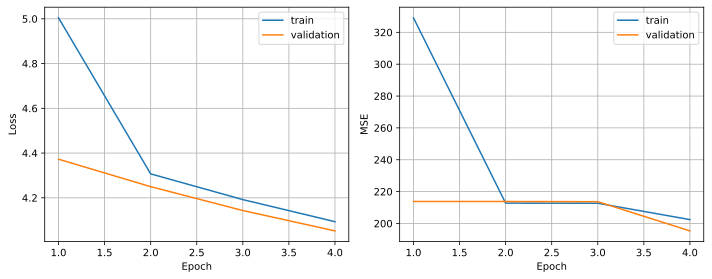

Validation MSE: 195.306


In [28]:
train_metric, val_metric = train_and_validate(model, optimizer, criterion, metric,train_loader=train_dl, val_loader=val_dl,num_epochs=epochs)### your code here

The constant turned out to be of better quality. The classifier here is bad because we will not be able to predict years for songs whose true year is greater than ours now. We also have very unbalanced classes, and it’s impossible to learn well with such a poor distribution.

<font color='brown'>**Exercise 4.** Now let's try to solve the problem as a regression. Train a neural network on MSE.
- Use the same training hyperparameters except learning rate (set it to 1e-6).
- When passing the target variable to the `TensorDataset`, do a reshape to `(-1, 1)` and convert to the `torch.float32`.
- Don't forget to change the lambda expression you pass to `train_and_validate`.
- If something goes wrong, you can try smaller `lr` values.
</font>

In [29]:
lr = 1e-6

In [30]:
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(target_val.reshape(-1, 1), dtype=torch.float32)) ### your code here
train_ds = TensorDataset( torch.tensor(X_train, dtype=torch.float32),torch.tensor(target_train.reshape(-1, 1), dtype=torch.float32)) ### your code here

assert len(val_ds) == 96627 and len(train_ds) == 289881

assert len(val_ds[0]) == 2 and len(train_ds[0]) == 2
assert val_ds[0][0].shape == (90, ) and val_ds[0][1].shape == (1, )
assert train_ds[0][0].shape == (90, ) and train_ds[0][1].shape == (1, )

val_ds[0]

(tensor([ 4.9814e+01,  2.1554e+01,  2.2072e+01, -4.0647e+00, -2.6312e+01,
         -2.1766e+01, -5.0466e+00, -5.0849e+00,  5.6026e+00,  4.7512e+00,
          1.0105e+00,  5.2294e+00,  5.8359e+01,  2.4072e+03,  8.3569e+02,
          3.3101e+02,  6.2257e+02,  3.2318e+02,  3.1044e+02,  2.7583e+02,
          1.5219e+02,  1.3494e+02,  1.2195e+02,  1.3037e+02,  2.4669e+02,
          2.3254e+02,  3.2583e+01,  4.0379e+01, -4.3841e+01,  5.6011e+01,
          4.0721e+01,  4.3293e+00,  1.1106e+01, -3.7591e+01,  2.4224e+01,
          1.3153e+02, -1.8483e+02,  1.8435e+02, -6.9555e+01, -1.1619e+02,
          2.2879e+01,  2.7762e+01, -3.4535e+00, -3.2331e+00, -8.0625e+00,
         -1.1110e+01,  2.0861e+02, -2.7882e+01, -4.8638e+01, -4.9602e+00,
          8.2225e+00,  3.7292e+01, -6.4772e+01, -1.9620e+01,  4.7428e+01,
         -4.3479e+01, -2.0609e+02, -9.2478e+01,  4.3857e+00, -1.5212e+01,
         -5.0137e+01, -1.0835e+01, -1.1184e+01, -5.0620e+01, -7.1401e+01,
          7.4009e+00, -3.2079e+01, -3.

In [31]:
val_dl = DataLoader(val_ds, batch_size=batch_size) ### your code here
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) ### your code here

assert len(next(iter(val_dl))) == 2 and len(next(iter(train_dl))) == 2
assert next(iter(val_dl))[0].shape == (batch_size, 90) and next(iter(train_dl))[0].shape == (batch_size, 90)
assert next(iter(val_dl))[1].shape == (batch_size, 1) and next(iter(train_dl))[1].shape == (batch_size, 1)

next(iter(val_dl))

[tensor([[ 4.9814e+01,  2.1554e+01,  2.2072e+01,  ..., -1.2075e+01,
          -4.6580e+01, -3.9084e+00],
         [ 5.1428e+01,  2.3087e+00,  2.3128e+01,  ...,  8.5168e+00,
           4.0356e+01, -3.8451e+00],
         [ 3.6790e+01, -4.6659e+01,  1.1820e-02,  ..., -1.1934e+01,
           3.2165e+02,  1.8429e+01],
         ...,
         [ 5.1643e+01,  2.1040e+01,  4.3191e+01,  ..., -1.7179e+00,
           9.0705e+01, -5.1544e-01],
         [ 4.4969e+01,  1.1906e+00,  9.7389e+00,  ...,  4.3515e+00,
           1.5496e+02,  6.3279e+00],
         [ 3.9654e+01, -6.8934e+01,  8.6260e-02,  ..., -9.1190e+00,
          -1.1726e+02,  7.2544e+00]]),
 tensor([[84.],
         [81.],
         [81.],
         [58.],
         [82.],
         [57.],
         [88.],
         [67.],
         [55.],
         [88.],
         [87.],
         [78.],
         [70.],
         [83.],
         [82.],
         [79.],
         [87.],
         [75.],
         [85.],
         [56.],
         [77.],
         [81.],
  

In [32]:
output_size = 1 ### your code here

assert output_size == next(iter(train_dl))[1].shape[1]

In [33]:
model = torch.nn.Sequential( torch.nn.Linear(input_size, hidden_size),torch.nn.ReLU(), torch.nn.Linear(hidden_size, output_size)) ### your code here

assert len(list(model.parameters())) == 4
assert sum(param.numel() for param in model.parameters()) == (90 * 128 + 128) + (128 * 1 + 1)

for name, param in model.named_parameters():
    print(name, param.shape)

model

0.weight torch.Size([128, 90])
0.bias torch.Size([128])
2.weight torch.Size([1, 128])
2.bias torch.Size([1])


Sequential(
  (0): Linear(in_features=90, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
)

In [34]:
criterion =torch.nn.MSELoss()### your code here

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)### your code here

assert sum(torch.allclose(_, __) for _, __ in zip(optimizer.param_groups[0]['params'], model.parameters())) == 4

<font color='brown'>You can use `torch.nn.MSELoss` to compute metric. To preserve semantics, let's return Python scalar from this function instead of `torch.Tensor` use [`.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item) method.</font>

In [36]:
metric = lambda preds, targets: torch.nn.MSELoss()(preds, targets).item()### your code here

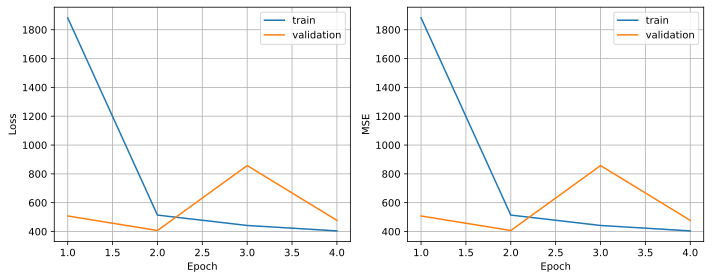

Validation MSE: 477.283


In [37]:
train_metric, val_metric =train_and_validate(model, optimizer, criterion, metric,train_loader=train_dl, val_loader=val_dl, num_epochs=4) ### your code here

It turns out that a random answer gives a smaller error, this all happens due to the uneven distribution of the target variable:

In [38]:
random_mse = mean_squared_error(y_test, np.random.choice(y_train, y_test.shape))
print(f'Random MSE: {random_mse}')

Random MSE: 237.460318076329


<font color='brown'>**Exercise 5.** Let's start by trying to normalize the target variable. To do this, we will use min-max normalization so that the target variable takes values from 0 to 1. Implement the `normalize` and `denormalize` functions, which, respectively, normalize the target variable and apply the inverse transformation. Estimate the minimum and maximum using the training sample (that is, these constants must be fixed and independent of the particular sample).</font>

In [39]:
target_train_min = target_train.min() ### your code here
target_train_max = target_train.max() ### your code here
diff = target_train_max - target_train_min ### your code here

def normalize(sample, target_train_min, diff):
    """
    Min-max normalization to convert sample to [0, 1] range
    """
    return (sample - target_train_min) / diff ### your code here

def denormalize(sample, target_train_min, diff):
    """
    Denormalize sample from [0, 1] to initial range
    """
    return sample * diff + target_train_min ### your code here

assert np.allclose(normalize(np.arange(6), 0, 5), np.array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))
assert np.allclose(denormalize(np.array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), 0, 5), np.arange(6))

print(target_train_min, diff)

0 89


<font color='brown'>**Exercise 6.** Now repeat the experiment from **Exercise 5**, training on the normalized target variable. Let's also make one more change: add `Sigmoid` activation after the last linear layer of the network. This way we guarantee that the neural network predicts numbers from the range $[0, 1]$. Using activation is a fairly common technique when we want to get numbers from a certain range of values.</font>

In [40]:
lr = 1e-5

In [41]:
val_ds =  TensorDataset( torch.tensor(X_val, dtype=torch.float32), torch.tensor(normalize(target_val, target_train_min, diff).reshape(-1, 1), dtype=torch.float32))  ### your code here
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(normalize(target_train, target_train_min, diff).reshape(-1, 1), dtype=torch.float32)) ### your code here

val_dl = DataLoader(val_ds, batch_size=batch_size)### your code here
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) ### your code here

model = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size),torch.nn.ReLU(),torch.nn.Linear(hidden_size, output_size),torch.nn.Sigmoid()) ### your code here

criterion =torch.nn.MSELoss() ### your code here
optimizer = torch.optim.SGD(model.parameters(), lr=lr) ### your code here

metric = lambda preds, targets: torch.nn.MSELoss()(preds * diff + target_train_min,targets * diff + target_train_min).item() ### your code here

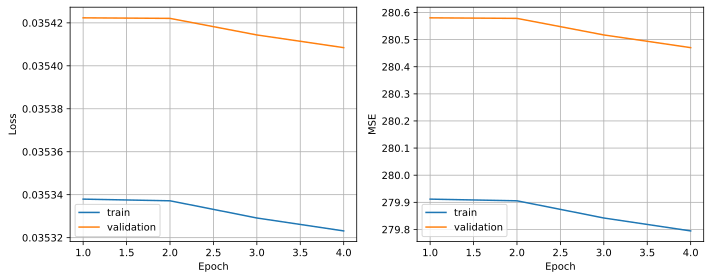

Validation MSE: 280.470


In [42]:
train_metric, val_metric = train_and_validate(model, optimizer, criterion, metric,train_loader=train_dl, val_loader=val_dl, num_epochs=epochs) ### your code here

The quality has become a bit better, but also does not reach the quality for the constant.

<font color='brown'>**Exercise 7.** This time we will try to normalize not only the target variable, but also the data itself that is supplied to the network as input. We will use normalization through the mean and standard deviation. Transform the data and repeat the previous experiment. Most likely, it makes sense to increase the number of training epochs.</font>

In [85]:
from sklearn.preprocessing import StandardScaler

In [86]:
lr = 1e-1

In [87]:
scaler = StandardScaler()### your code here
### your code here
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

val_ds = TensorDataset( torch.tensor(X_val_scaled, dtype=torch.float32),torch.tensor( normalize(target_val, target_train_min, diff).reshape(-1, 1), dtype=torch.float32))### your code here
train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),torch.tensor(normalize(target_train, target_train_min, diff).reshape(-1, 1), dtype=torch.float32))### your code here

val_dl = DataLoader(val_ds, batch_size=batch_size) ### your code here
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) ### your code here

model = torch.nn.Sequential( torch.nn.Linear(input_size, hidden_size),torch.nn.ReLU(),torch.nn.Linear(hidden_size, output_size),torch.nn.Sigmoid()) ### your code here

criterion = torch.nn.MSELoss() ### your code here
optimizer = torch.optim.SGD(model.parameters(), lr=lr) ### your code here

metric = lambda preds, targets: mean_squared_error(preds.detach().cpu().numpy() * diff +target_train_min,targets.detach().cpu().numpy()* diff +target_train_min)### your code here

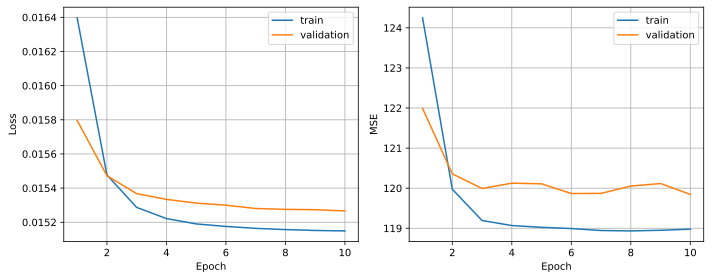

Validation MSE: 119.845


In [88]:
train_metric, val_metric = train_and_validate(model, optimizer, criterion, metric,train_loader=train_dl, val_loader=val_dl,num_epochs=10) ### your code here

If you did everything correctly, then you should have a quality comparable to `Ridge` regression.

**Moral:** As you can see, we had to do a lot of tricky things to make the neural network work at least as well as a simple linear model. Here, of course, we show a very extreme case when, without data normalization, the neural network simply does not learn. As a rule, in reality, setting up a neural network out of the box is not very difficult, but getting it to work to its full potential — a much more labor-intensive task. Writing pipelines for training neural network models requires great care, and debugging often turns into a guessing game. Fortunately, intuition often comes to the rescue, and we hope that you will be able to develop it during our course. Let's start with two tips that are worth taking into account:

- We definitely start any experiments with baselines: without them, we would not understand that the neural network does not learn in principle.
- When setting up experiments, try to make a minimum number of changes at a time (ideally one!): this is the only way to understand what specific changes affect the result.

<font color='brown'>**Exercise 8.** Now, when we get appropriate quality we can try to use some advanced technics in our model. Apply those changes and repeat experiment one more time:

1. Increase hidden size up to $256$
2. Add one more hidden layer
3. Use more advanced optimizer: [`torch.nn.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
4. Add `torch.nn.BatchNorm1d` after all layers except the last one. You can read about Batch Norm [here](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) or in 11th week lecture.
5. Add [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after all layers except the last one with moderate `p` value to decrease overfitting. You can read about Dropout [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).
</font>

In [89]:
p = 0.2
lr = 1e-3

hidden_size =256 ### your code here

In [103]:
scaler = StandardScaler()### your code here
### your code here
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(normalize(target_val.reshape(-1, 1).astype(np.float32), target_train_min, diff), dtype=torch.float32)) ### your code here
train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),torch.tensor(normalize(target_train.reshape(-1, 1).astype(np.float32), target_train_min, diff), dtype=torch.float32)) ### your code here

val_dl =  DataLoader(val_ds, batch_size=batch_size) ### your code here
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) ### your code here

model = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size),torch.nn.BatchNorm1d(hidden_size),torch.nn.ReLU(),torch.nn.Dropout(p),torch.nn.Linear(hidden_size, hidden_size),torch.nn.BatchNorm1d(hidden_size),torch.nn.ReLU(),torch.nn.Dropout(p),torch.nn.Linear(hidden_size, 1), torch.nn.Sigmoid())### your code here

criterion = torch.nn.MSELoss() ### your code here
optimizer = torch.optim.Adam(model.parameters(),lr=lr) ### your code here

metric = lambda preds, targets: mean_squared_error(denormalize(preds.detach().cpu().numpy(), target_train_min, diff),denormalize(targets.detach().cpu().numpy(), target_train_min, diff))### your code here

model

Sequential(
  (0): Linear(in_features=90, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=256, out_features=1, bias=True)
  (9): Sigmoid()
)

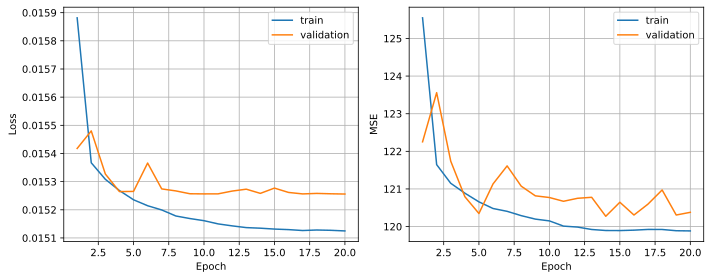

Validation MSE: 120.379


In [104]:
train_metric, val_metric =train_and_validate(model,optimizer, criterion,metric,train_loader=train_dl, val_loader=val_dl,num_epochs=20) ### your code here